<a href="https://colab.research.google.com/github/rakibulhaque9954/sec-22-Image-generation-GANs/blob/main/sec_22_Image_generation_GAN's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High Level Overview

## Introdcution

1. Generator: The generator's job is to create fake data, in this case, typically images. It starts with random noise as input and gradually learns to generate data that looks increasingly like real data. The generator tries to produce data that is indistinguishable from real data.

2. Discriminator: The discriminator's role is to distinguish between real data and fake data generated by the generator. It is essentially a binary classifier that is trained on real and fake examples. The discriminator learns to assign a high probability to real data and a low probability to fake data.

The training process of a GAN involves a back-and-forth competition between the generator and discriminator:

1. Initially, the generator produces poor-quality fake data, and the discriminator can easily tell that it's fake. The discriminator provides feedback to the generator about the shortcomings of the generated data.

2. The generator uses this feedback to adjust its parameters (weights and biases) and improve the quality of its generated data. It aims to produce data that can better fool the discriminator.

3. Simultaneously, the discriminator also continues to improve its ability to distinguish real from fake data, as it receives more examples of both.

4. This adversarial training process continues iteratively until a certain convergence criterion is met. Ideally, the generator gets better at generating realistic data, and the discriminator gets better at distinguishing real from fake data.

The ultimate goal is to reach a point where the generator generates data that is so realistic that the discriminator can no longer confidently distinguish it from real data. At this point, the GAN has reached a Nash equilibrium, and the generated data is considered highly convincing.

GANs have been widely used in various applications, including image generation, style transfer, image-to-image translation, and more, thanks to their ability to generate realistic and high-quality data.

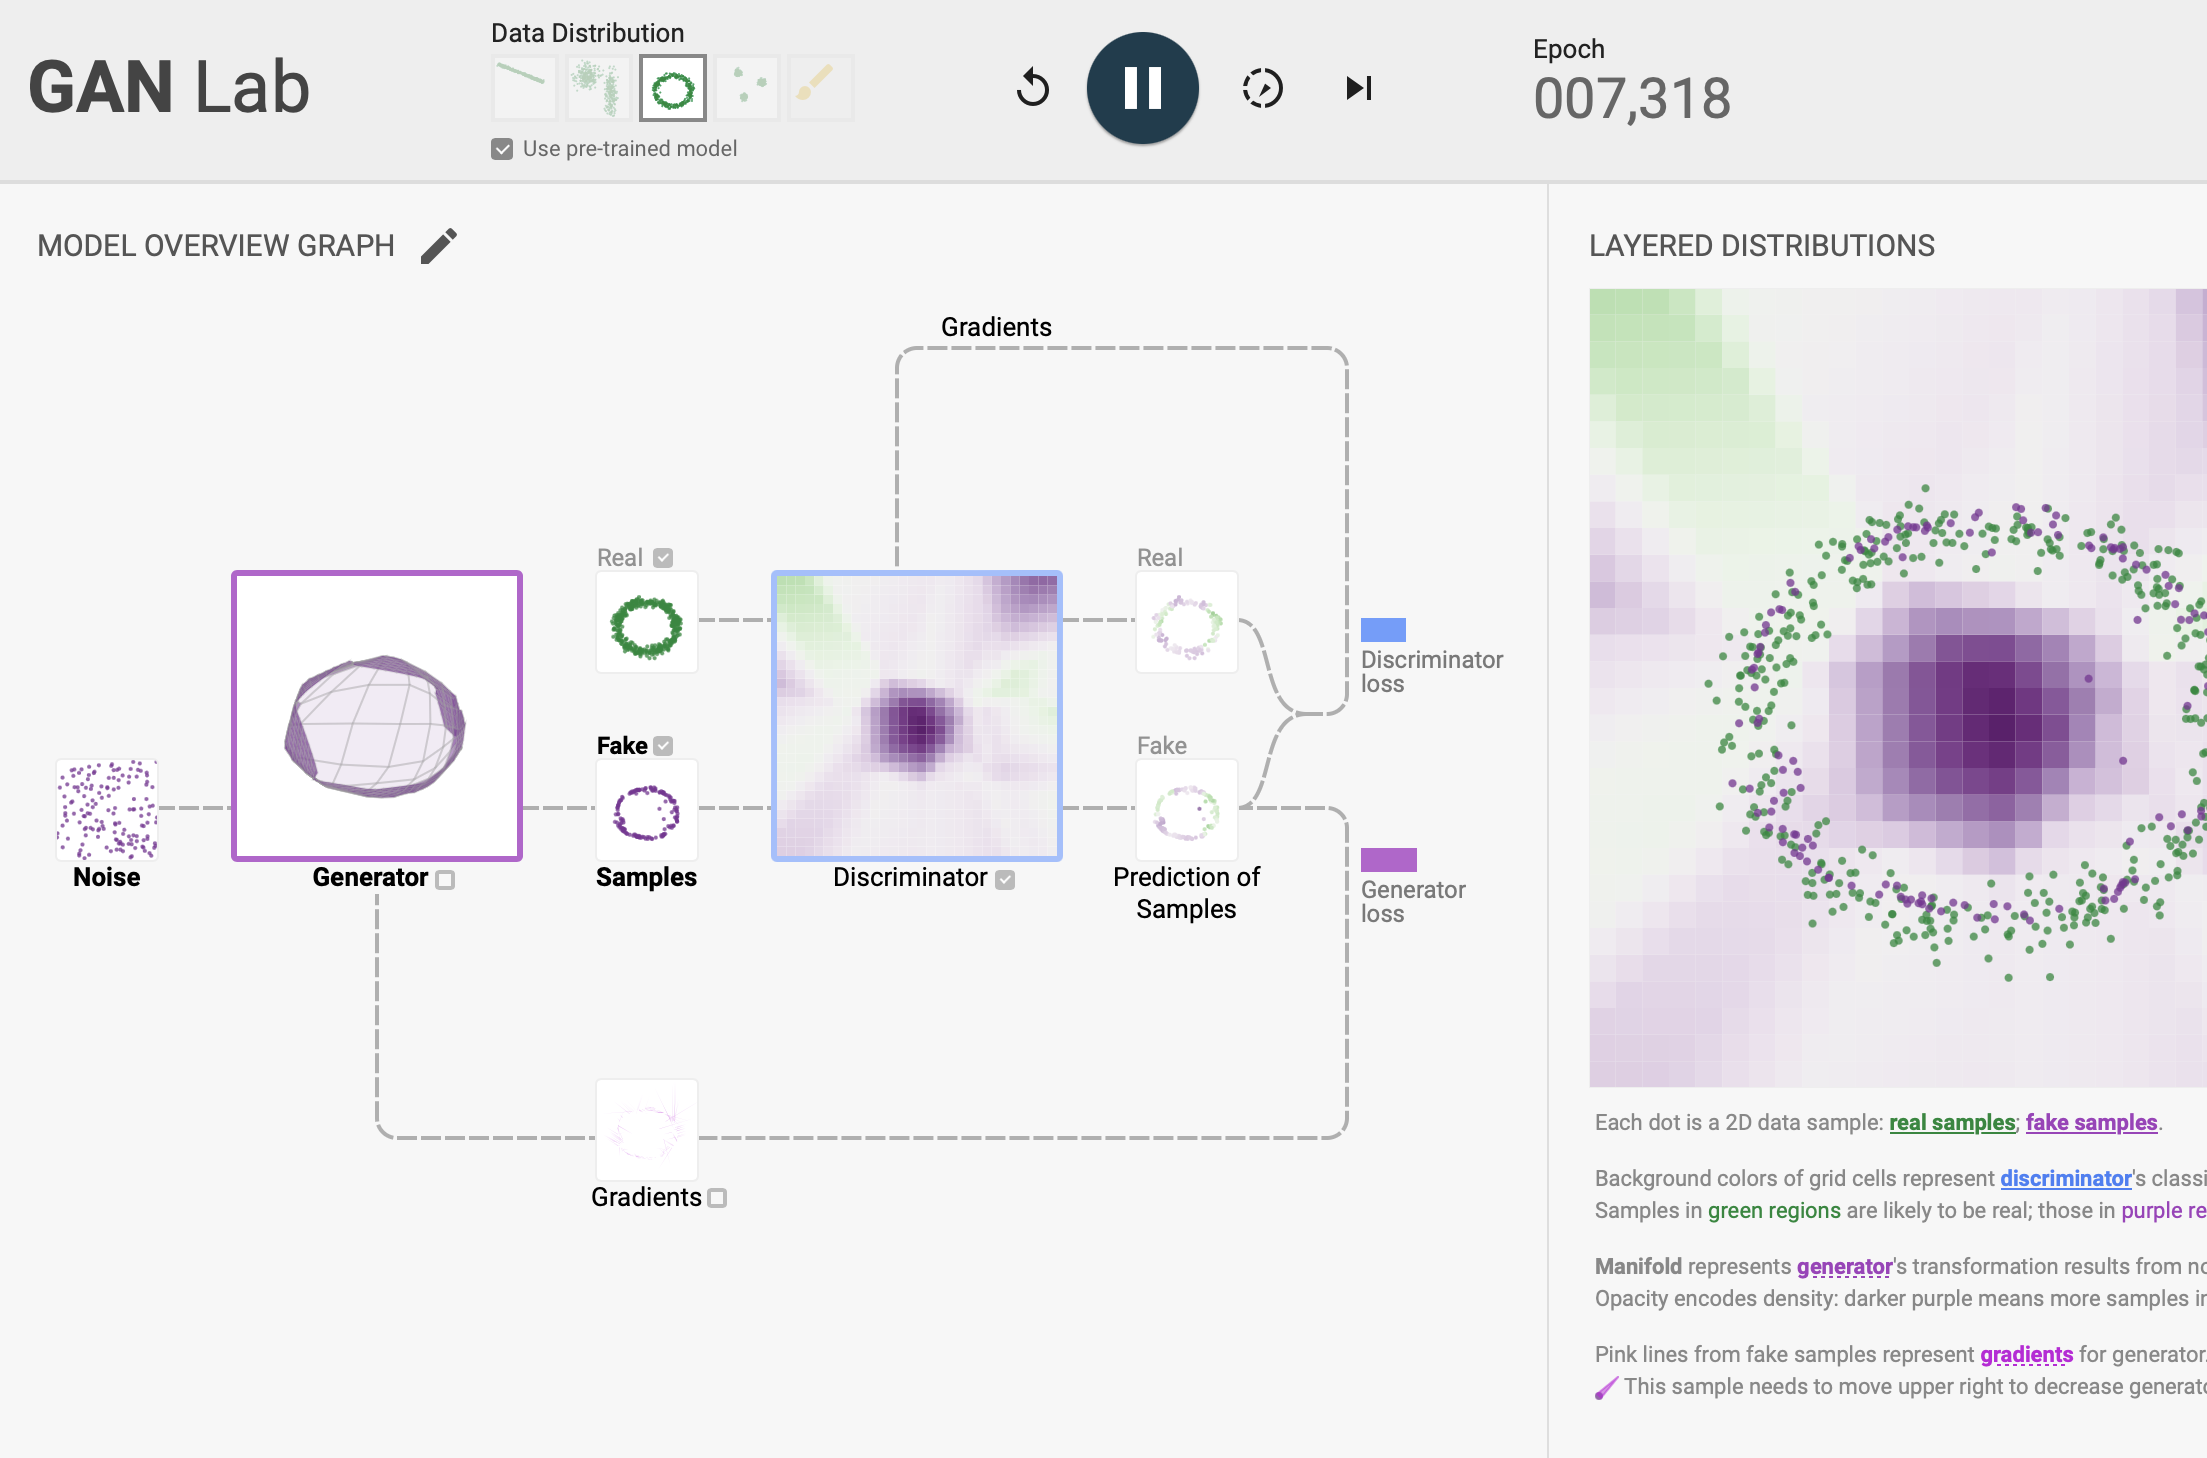

## GAN Loss


1. Initially, the generator's loss (G loss) is high because it's generating random noise, and the discriminator's loss (D loss) is low because it can easily distinguish real from fake.

2. As training progresses, the generator improves, and its loss decreases because it generates data that looks more like the real thing. Simultaneously, the discriminator gets better at its job, and its loss also decreases as it becomes more skilled at distinguishing real and fake data.

3. The training continues until a point where both losses converge to around 0.5. At this stage, the generator produces data that is so realistic that the discriminator can't reliably tell real from fake. This is the equilibrium you want to achieve in a GAN, where the generator creates high-quality data that closely resembles real data, and the discriminator is effectively guessing.

This is the GAN's sweet spot, and we say it has reached a Nash equilibrium.

Breakdown:
- **Generator (G):** BCE loss for G aims to be lower because G wants to create synthetic data (images, in most cases) that is as close to real data as possible. From G's perspective, lower BCE loss means that the discriminator is having a harder time distinguishing its generated data from real data. So, G strives to minimize its loss to produce more convincing and realistic data.

- **Discriminator (D):** On the other hand, BCE loss for D aims to be maximized (or its negative loss minimized) because D wants to become a better discriminator. Higher BCE loss from D's perspective means that it's having difficulty distinguishing real from fake data, which indicates that G is doing a better job at generating realistic data. So, D aims to maximize its loss by becoming more discerning.

We have two BCE's for G and D both working Opposite direction as guided by the Optimizer.

<h3>Optimized Loss Function Practice during Training:</h3>
Let's break it down further:

- In the early stages of training a GAN, the discriminator (D) can be too confident in its predictions. When using the standard BCE loss, if D is confident that a generated image is fake (assigns it a low probability close to 0), the loss can become saturated, and the gradients for the generator (G) can become extremely small. This means G may not receive strong feedback to improve its generated images.

- To address this issue, a modification is sometimes made to the BCE loss for the generator. Instead of minimizing **`log(1 - D)`** (where `y` is 0 for fake data), it's maximized by minimizing **`-log(D)`** (where `y` is 1 for fake data). This effectively encourages the generator to generate data that has a higher probability of being considered real by the discriminator, especially in the early stages of training.

- By maximizing **`log(D)`**, the generator receives a more informative gradient signal, even when D is confident that the generated data is fake. This encourages the generator to adjust its weights and biases to produce data that is less easily classified as fake by D, thus starting the learning process effectively.

The Points above highlights the practical adjustments made during GAN training to ensure that the generator receives sufficient feedback early in training, helping it produce better-quality images and preventing D from being too confident too soon. This modification is a common practice in GAN training to improve stability and convergence. Flipping Labels, (real = fake : fake = real)

One of the authors github has tips, here is the forked version: https://github.com/rakibulhaque9954/ganhacks

# Imports

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Layer
from keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from keras.optimizers import Adam

# Data Preparation

## Kaggle Dataset Download

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip '/content/celeba-dataset.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/dat

## Preprocessing Data

In [65]:
BATCH_SIZE = 128
IM_SHAPE = (64, 64, 3)
LR = 2e-4
LATENT_DIM = 100 # max hidden features captured

In [70]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/img_align_celeba/img_align_celeba', label_mode = None, image_size = (IM_SHAPE[0], IM_SHAPE[1]), batch_size = BATCH_SIZE
)

Found 202599 files belonging to 1 classes.


In [71]:
dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

### Preprocess Function

In [72]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0 # 127.5 is basically mean-centering then after that we obtain value that we  subtract from 1 which makes the value fall within -1 to 1 is used by activation functions
  # this method is used for GAN's normally for image classification value between 0 and 1 is used which image/255.0
  # the model's architecture and choice of activation functions play a big role in deciding the preprocessing methods, but softmax and sigmoid are more based on 0, 1 value so for them image/255.0 is a better approach

### Batching

In [73]:
train_dataset= (
    dataset
    .map(preprocess)
    .unbatch() # unbatching to shuffle the datapoints and drop remainder
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE, drop_remainder = True) # dropping unmatched bacthes
    .prefetch(tf.data.AUTOTUNE)
)

### Visualization of Dataset

In [35]:
for data in train_dataset.take(1):
  print(data.shape)

(128, 64, 64, 3)


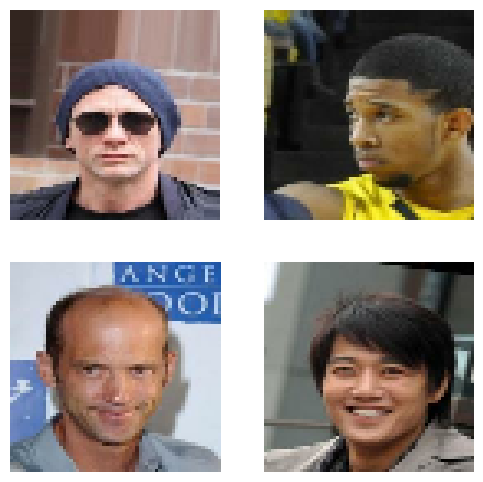

In [36]:
plt.figure(figsize = (6, 6))
k = 0
n = 4
for i in range(n):
  ax = plt.subplot(2, 2, k + 1)
  plt.imshow((data[i] + 1) / 2) # just for visualizing since our data was prepocessed to fall in range between -1, 1 the images werent clear thats why converted them to fall in range 0, 1
  # by adding 1 and then getting the mean d[i] + 1 / 2
  plt.axis('off')
  k += 1

# Modeling

## Generator Model

In [74]:
generator = tf.keras.Sequential([
    Input(shape=(LATENT_DIM)),
    Dense(4 * 4 * LATENT_DIM),
    Reshape((4, 4, LATENT_DIM)),

    Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),  # kernel size should be divisble by strides for quality of the outputs
    BatchNormalization(),
    LeakyReLU(0.2), # alpha set to 0.2 which is the scale down value, suppose the gradient is -0.2 then the output would gradient * alpha which is -0.2 * 0.2 which -0.04
    # it reduces by a factor of 0.2

    Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),


    Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(3, kernel_size = 4, strides = 2, padding = 'same', activation = tf.keras.activations.tanh), # maps values between -1 and 1


], name = 'generator')

Slowly and steadily Upsampling image

In [75]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1600)              161600    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 8, 8, 512)         819712    
 Transpose)                                                      
                                                                 
 batch_normalization_5 (Bat  (None, 8, 8, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 16, 16, 256)       20

# Discriminator Model

In [76]:
discriminator = tf.keras.Sequential([
    Input(shape=(IM_SHAPE[0], IM_SHAPE[1], 3)),

    Conv2D(64, kernel_size = 4, strides = 2, padding = 'same'),  # kernel size should be divisble by strides for quality of the outputs
    LeakyReLU(0.2),

    Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),


    Conv2D(256, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(1, kernel_size = 4, strides = 2, padding = 'same'),

    Flatten(),

    Dense(1, activation = 'sigmoid') # value is in between 0 and 1


], name = 'discriminator')

Normally if there is no activation functions mentioned then there is no activation taking place and output is passed to the next layer without any non-linear transformations, f(x)=x.

In [77]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_8 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 256)         524544    
                                                     

## Override Train Step for Customization

In [82]:
class GAN1(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN1,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  """ Models Compilation """
  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN1,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn # BCE(Binary Cross Entropy)
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    """ Discriminator """
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    fake_images=self.generator(random_noise)

    real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)
     # random labels are assigned from thet get go for smooth training(label smoothing)
    with tf.GradientTape() as recorder:
      real_predictions=self.discriminator(real_images)
      d_loss_real=self.loss_fn(real_labels,real_predictions)
      # comparing the predictions to higher probability or 1

      fake_predictions=self.discriminator(fake_images)
      d_loss_fake=self.loss_fn(fake_labels,fake_predictions)
      # comparing the predictions to lower probability or 0

      d_loss=d_loss_real+d_loss_fake
      # total discriminator loss

    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))
    # updating weights and biases through back propogation with the help of gradient tape of Discriminator
    # Discriminator tries to reduce loss in the Ascent direction

    """ Generator """
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    flipped_fake_labels=tf.ones((batch_size,1)) # like the one in paper for the kickstart

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)
      # only on loss for g because its making only fake images

    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))
    # updating weights and biases through back propogation with the help of gradient tape of Generator
    # Discriminator tries to reduce loss in the Descent direction for Higher quality of Fake images

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    # loss update

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

Gradient Tape is a key component of backpropagation, which is the process used to train neural networks by iteratively adjusting model parameters to minimize the loss function. In essence, Gradient Tape plays a vital role in both forward and backward passes, making it possible to perform automatic differentiation and train deep learning models effectively.

# Callbacks

## Checkpoint Callback

In [86]:
from keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint("//content/drive/MyDrive/Colab Notebooks/DCGAN Model/DCGAN-celebs-v1", save_best_only=True)

## Show Image Callback Method

In [89]:
!mkdir generated4

In [90]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n = 6
        k = 0
        out = self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize = (16,16))
        for i in range(n):
          for j in range(n):
            ax = plt.subplot(n, n, k+1)
            plt.imshow((out[k] +1 ) / 2,) # making the output in between 0 and 1 like before
            plt.axis('off')
            k += 1
        plt.savefig("generated4/gen_images_epoch_{}.png".format(epoch+1))

This class helps in debugging by showing what the model is generating after each epoch.

# Model Compilation and Training

In [91]:
gan = GAN1(discriminator, generator)

gan.compile(
    d_optimizer = tf.keras.optimizers.Adam(learning_rate = LR, beta_1 = 0.5),
    g_optimizer = tf.keras.optimizers.Adam(learning_rate = LR, beta_1 = 0.5), # thats the nash equillibrium point
    loss_fn = tf.keras.losses.BinaryCrossentropy(),
)

In [ ]:
history = gan.fit(train_dataset, epochs = 300, callbacks = [ShowImage(LATENT_DIM), checkpoint_callback])

Epoch 1/300
      6/Unknown - 7s 193ms/step - d_loss: 1.1568 - g_loss: 0.8940

    541/Unknown - 105s 183ms/step - d_loss: 1.1511 - g_loss: 0.9830

# Model loss Visualization

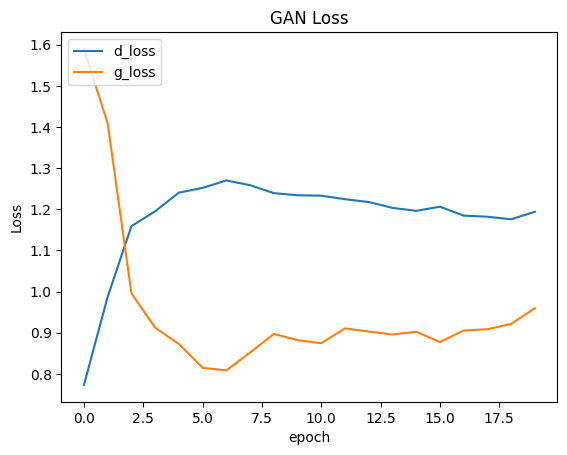

In [85]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()